In [2]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/content/drive/MyDrive/ml') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

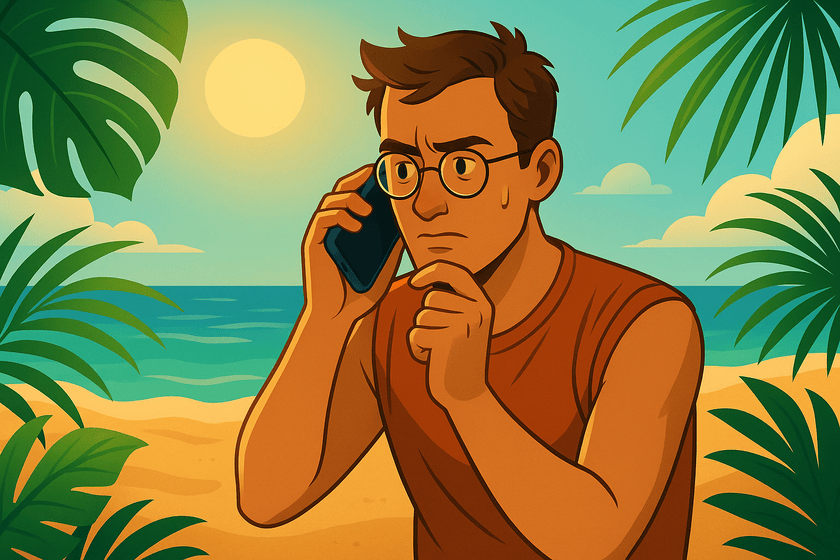

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [4]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [5]:
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [6]:
titanic_df.isnull().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,98
Cabin,687


Szybko przygotuję dataframe do pracy zgodnie z poprzednim zadaniem i jeszcze dodam i usunię kilku rzeczy

In [7]:
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df.groupby(['Sex', 'Pclass'])['Age'].transform('median'))

In [8]:
titanic_df['Fare'] = titanic_df['Fare'].fillna(titanic_df.groupby(['Pclass', 'Embarked'])['Fare'].transform('median'))

In [9]:
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('Unknown')
titanic_df['Deck'] = titanic_df['Cabin'].str[0].fillna('Unknown')

Nie dodałem kolumny Has_Cabin bo w moim zdaniu jest za bardzo podobna do Deck ale pokazuje mniej informacji

In [10]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])

In [11]:
titanic_df = titanic_df.convert_dtypes()

In [12]:
titanic_df.dtypes

,0
Survived,Int64
Pclass,Int64
Name,string[python]
Sex,string[python]
Age,Float64
SibSp,Int64
Parch,Int64
Ticket,string[python]
Fare,Float64
Cabin,string[python]


In [13]:
titanic_df.isnull().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,0


In [14]:
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 0, 'female': 1})
titanic_df['Embarked'] = titanic_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [15]:
titanic_df['Deck'] = titanic_df['Deck'].map({
    'A': 8,
    'B': 7,
    'C': 6,
    'D': 5,
    'E': 4,
    'F': 3,
    'G': 2,
    'T': 1,
    'U': 0
})

In [16]:
titanic_df = titanic_df.drop(['Name', 'Ticket'], axis=1)

In [17]:
titanic_df = titanic_df.drop(['Cabin'], axis=1)

In [18]:
titanic_df['Family_Size'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
titanic_df = titanic_df.drop(['SibSp', 'Parch'], axis=1)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
def plot_correlation_matrix(df):
    """
    Plots a heatmap showing the correlation matrix for numeric columns in the DataFrame.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing numeric data.
    Returns:
        None. Displays the correlation heatmap.
    """
    # compute correlation matrix only for numeric columns
    corr = df.corr(numeric_only=True)

    # fmt=".2f" rounds the number to 0.01
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

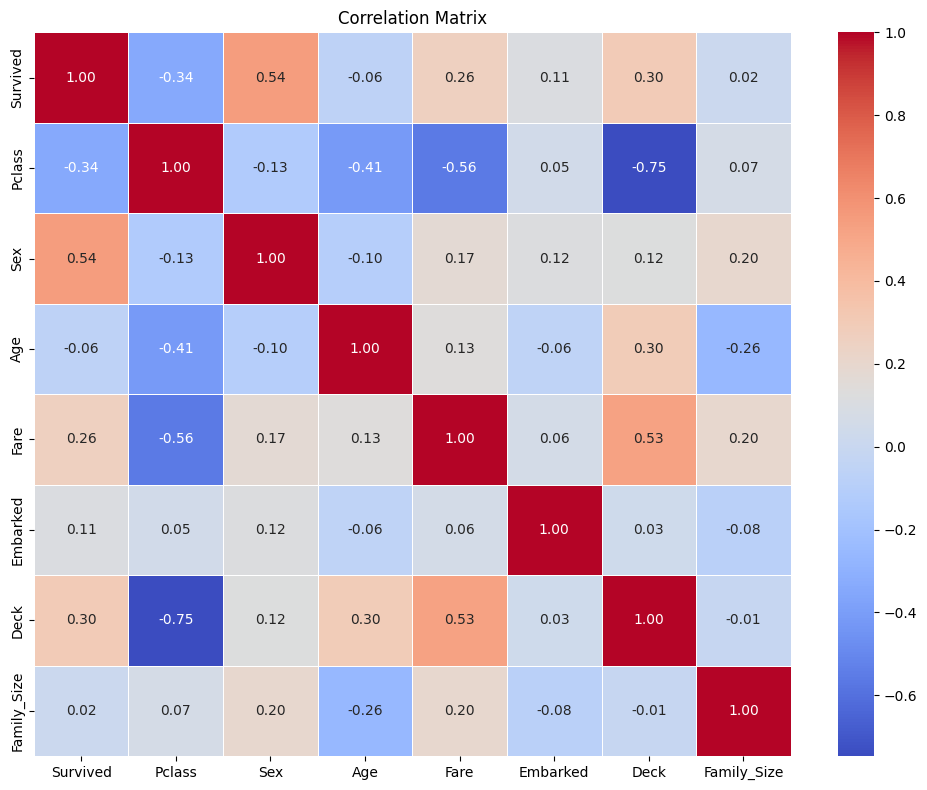

In [21]:
plot_correlation_matrix(titanic_df)

Dobrze myślę że wygląda dopóki uzyskane wyniki i zacznię od przygotowania danych do ML

In [22]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [23]:
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True)

Choćby magiczne linijki kodu były wzięte z lekcji, ale spróbuję uzasadnić ich wybór:

*   Accuracy - ile poprawno było klasyfikowano ludzi w odnoszeniu do całej liczby pasażerów. Prosto zrozumieć i porównywać modele, ale za bardzo upraszcza i po to korzystamy jeszcze z precision i recall
*   Precision - ile poprawno sklasyfikowano jako survived z wszystkich sklasyfikowanych jako survived. Ważne jest żeby zrozumieć ile było które naprawde przeżyły
*   Recall - ile z osób które przeżyły model potrafił znaleźć

Najpierw stworzymy Baseline DummyClassifier żeby można było z nim porównywać nasz model

In [25]:
model = DummyClassifier(strategy = 'uniform')
model.fit(X_train, y_train) # uczenie
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.55      0.47      0.51       106
         1.0       0.36      0.44      0.40        73

    accuracy                           0.46       179
   macro avg       0.46      0.46      0.45       179
weighted avg       0.47      0.46      0.46       179



array([[50, 56],
       [41, 32]])

Wynik accuracy jest 46% co jest zgodnie ze strategią uniform. Dla ludzi które przeżyły znacznie gorzej klasyfikuje niż dla ofiar i to jeszcze będzie można zobaczyć na przykładach następnych modeli

Drugi wybrany model jest DecisionTreeClassifier

In [58]:
model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       106
         1.0       0.79      0.66      0.72        73

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



array([[93, 13],
       [25, 48]])

Zgodnie z otrzymanymi wynikami widać że model lepiesz działa w klasyfikacji ofiar spośród pasażerów niż osób które przeżyły. Precision do obu klas jest taki samy i wyznacza ile procentowo ludzie klasyfikowanych odpowiednio było naprawde z tej klasy. Recall jest większy dla klasy 0, co znaczy że model poprawnie wyznaczył klasę dla 88% pasażerów z ofiar i tylko 66% osób które przeżyły zostały poprawnie sklasyfikowane.

Póżnio zrozumiałem że potrzebna wizualizacja dla każdej modeli z minimalnie dwoma hiperparametrami. Dlatego po każdej modeli zostało dodano dwie funkcji, pierwsza musi zwrócić wyniki przetrenowanego modelu zgodnie z hiperparametrami w param_grid, a druga musi to zwizualizować.

In [135]:
from sklearn.model_selection import GridSearchCV, cross_val_score

def hyperparameter_search_with_visualization():
    param_grid = {
        'max_depth': [3, 5, 7, 10, 15],
        'min_samples_split': [2, 5, 10, 20],
    }

    model = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy',
                              return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    results_df = pd.DataFrame(grid_search.cv_results_)

    return results_df

In [136]:
def create_visualizations(grid_search, results_df):
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 15))

    plt.subplot(3, 3, 1)
    depth_results = results_df.groupby('param_max_depth').agg({
        'mean_test_score': 'mean',
        'std_test_score': 'mean'
    }).reset_index()

    plt.errorbar(depth_results['param_max_depth'], depth_results['mean_test_score'],
                yerr=depth_results['std_test_score'], marker='o', capsize=5)
    plt.title('Max deapth')
    plt.xlabel('Max Depth')
    plt.ylabel('Cross-validation Accuracy')
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 3, 2)
    split_results = results_df.groupby('param_min_samples_split').agg({
        'mean_test_score': 'mean',
        'std_test_score': 'mean'
    }).reset_index()

    plt.errorbar(split_results['param_min_samples_split'], split_results['mean_test_score'],
                yerr=split_results['std_test_score'], marker='s', capsize=5, color='orange')
    plt.title('Min samples')
    plt.xlabel('Min Samples Split')
    plt.ylabel('Cross-validation Accuracy')
    plt.grid(True, alpha=0.3)

Po tej wizualizacji widać że zwiększenie max_deapth wpływa na Accuracy negatywnie zmniejszając ją wraz ze wzrostem max_deapth. Odwrotnie sytuacji z min_samples. Z tego co ja rozumiem się dzieje to sytuacja jest taka, że niskie wartości max_deapth grożą undefitting, a wysokie overfitting i na odwrót z min_samples.

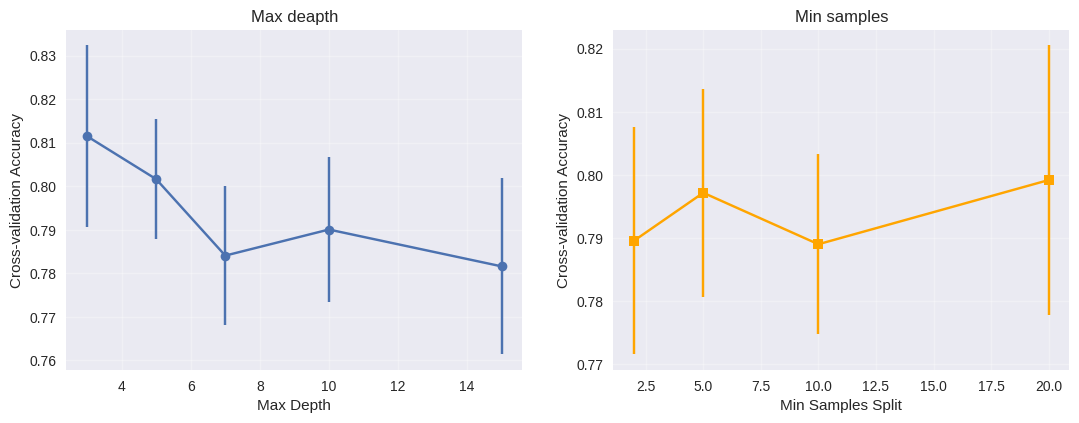

In [120]:
results_df = hyperparameter_search_with_visualization()
create_visualizations(results_df)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

Drugim modelem było wybrano SVM

In [107]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVC(kernel='linear')  # liniowe SVM
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82       106
         1.0       0.77      0.64      0.70        73

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.78      0.78      0.77       179



array([[92, 14],
       [26, 47]])

Widać że wyniki są bardzo podobne do modeli pierwszej DecisionTree: podobne precision, wysoki recall dla ofiar i niższy dla osób które przeżyły

In [143]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def svm_hyperparameter_search():

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = [
        {
            'kernel': ['linear'],
            'C': [0.01, 0.1, 1, 10, 100],
            'class_weight': [None, 'balanced']
        },

        {
            'kernel': ['rbf'],
            'C': [0.01, 0.1, 1, 10, 100],
            'class_weight': [None, 'balanced']
        },

        {
            'kernel': ['poly'],
            'C': [0.01, 0.1, 1, 10, 100],
            'class_weight': [None, 'balanced']
        }
    ]

    grid_search = GridSearchCV(
        SVC(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    grid_search.fit(X_train_scaled, y_train)

    return pd.DataFrame(grid_search.cv_results_)



In [144]:
def visualize_svm_hyperparameters(results_df):

    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 15))

    plt.subplot(3, 3, 1)
    kernel_results = results_df.groupby('param_kernel').agg({
        'mean_test_score': ['mean', 'std']
    }).round(4)
    kernel_results.columns = ['mean_accuracy', 'std_accuracy']

    kernels = kernel_results.index.tolist()
    means = kernel_results['mean_accuracy'].tolist()
    stds = kernel_results['std_accuracy'].tolist()

    plt.bar(kernels, means, yerr=stds, capsize=5, alpha=0.8,
            color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Different kernels')
    plt.ylabel('Cross-validation Accuracy')
    plt.xlabel('Kernel Type')
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 3, 2)
    c_values = [0.01, 0.1, 1, 10, 100]
    c_accuracies = []
    c_stds = []

    for c in c_values:
        c_mask = results_df['param_C'] == c
        if c_mask.any():
            c_acc = results_df[c_mask]['mean_test_score'].mean()
            c_std = results_df[c_mask]['mean_test_score'].std()
            c_accuracies.append(c_acc)
            c_stds.append(c_std)
        else:
            c_accuracies.append(np.nan)
            c_stds.append(np.nan)

    valid_indices = ~np.isnan(c_accuracies)
    valid_c = np.array(c_values)[valid_indices]
    valid_acc = np.array(c_accuracies)[valid_indices]
    valid_std = np.array(c_stds)[valid_indices]

    plt.semilogx(valid_c, valid_acc, 'bo-', linewidth=2, markersize=8)
    plt.fill_between(valid_c, valid_acc - valid_std, valid_acc + valid_std, alpha=0.2)
    plt.title('Different C')
    plt.xlabel('C')
    plt.ylabel('Cross-validation Accuracy')
    plt.grid(True, alpha=0.3)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


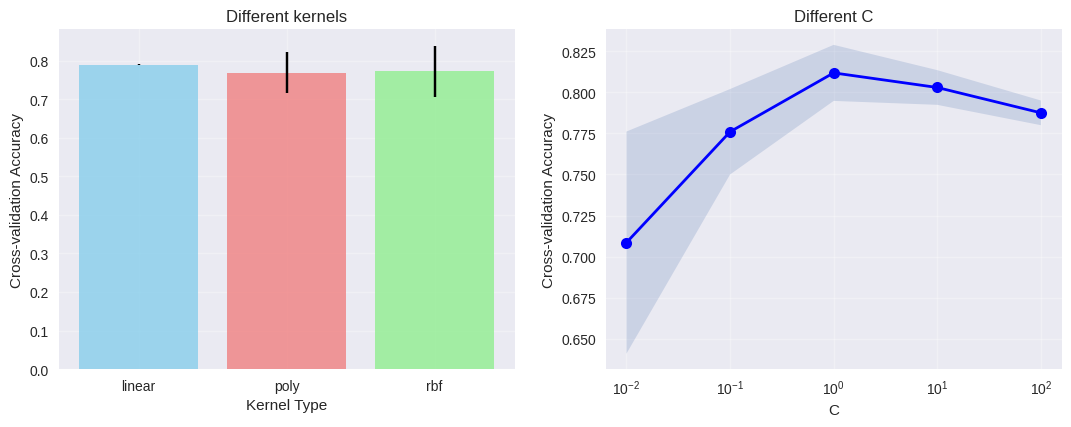

In [145]:
results_df = svm_hyperparameter_search()
visualize_svm_hyperparameters(results_df)

Widać na wykresach wpływ kernel i że najlepszym jest linear. Dla C było uśrednione wartości dla linear, poly i rbf ale nawet tak widać krzywą: małe wartości grożą underfitting, 1 jest najlepszym wyborem za wysokim accuracy, a większe wartości dają overfitting.

W moim zdaniu lepiej modeli klasyfikują ofiar niż ludzi które przeżyły dlatego że ofiar było po prostu więcej na Tytanicu

In [152]:
titanic_df['Survived'].value_counts().sort_index()

,count
Survived,
0,549
1,342
